# Healthkit ECG Extract

Newer Apple watches include 'ECG' functionality, however there is currently no public API to access ECG data.

This notebook attempts to recreate the ECG data using the exported PDF of the ECG report.

1. PDF was converted to png using preview.
2. ECG sections of the report are extracted and stitched together.
3. Waveform is pulled out using argmin
4. Analysis of ECG using heartpy

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


ecg_pdf_filename = Path('images/ECG_img.png')

im = Image.open(ecg_pdf_filename)
im_arr = np.array(im)
im_arr.shape

(1275, 1650, 4)

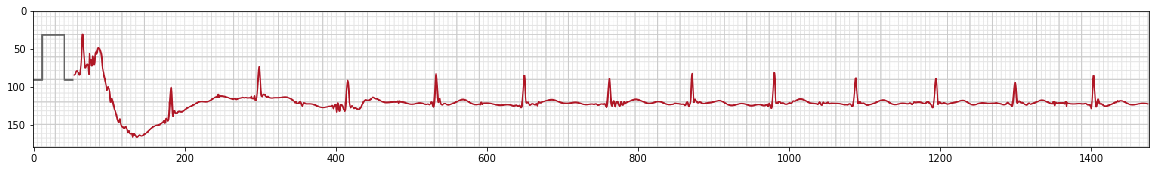

In [2]:
plt.figure(figsize=(20,5))
plt.imshow(im_arr[453:633,83:-90,:]);

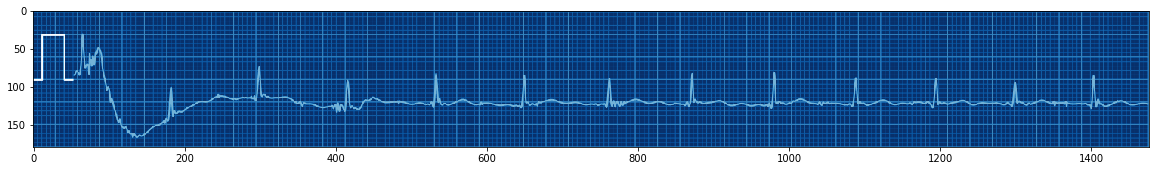

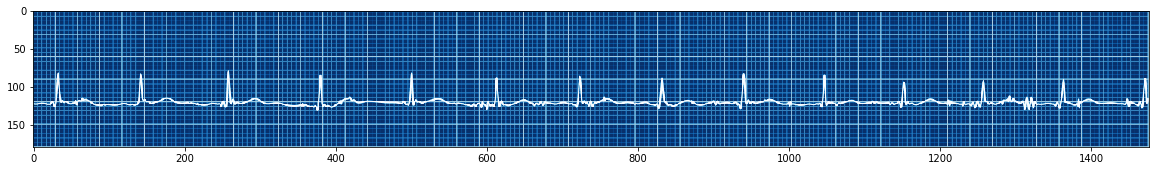

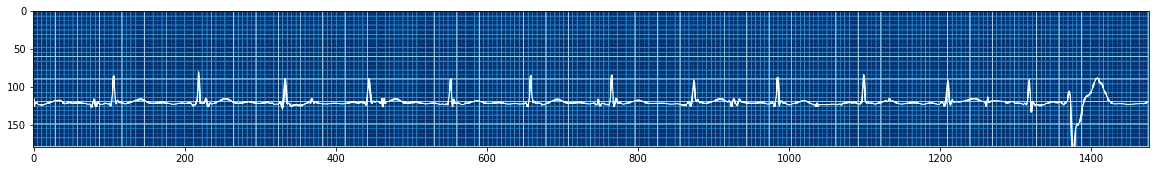

In [3]:
arr_0 = im_arr[453:633,83:-90,0]
arr_1 = im_arr[671:851,83:-90,0]
arr_2 = im_arr[889:1069,83:-90,0]

plt.figure(figsize=(20,20))
plt.imshow(arr_0, cmap='Blues');
plt.figure(figsize=(20,20))
plt.imshow(arr_1, cmap='Blues');
plt.figure(figsize=(20,20))
plt.imshow(arr_2, cmap='Blues');

In [4]:
# pull out waveform using argmin (subtract from 180 as signal will be flipped)
recreated_ecg_arr = 180-np.hstack([arr_0, arr_1, arr_2]).argmin(axis=0)

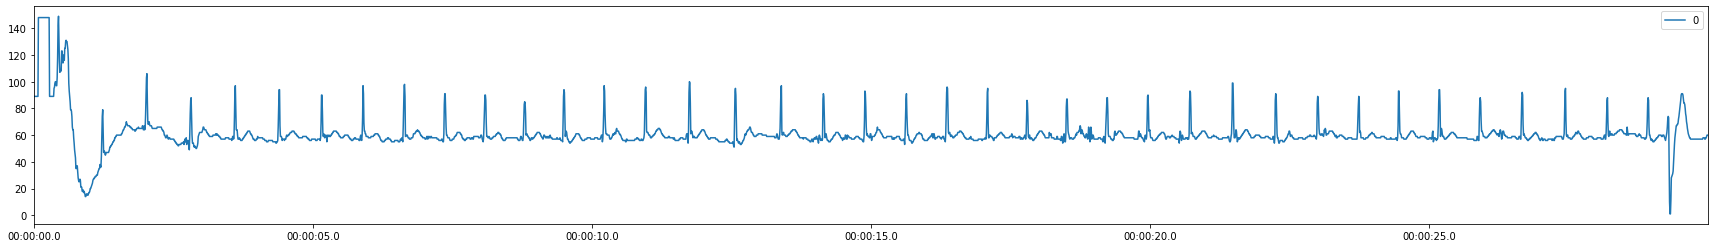

In [5]:
recreated_ecg = (pd.DataFrame(recreated_ecg_arr, 
                             pd.timedelta_range('0S', '30S', len(recreated_ecg_arr)+1, closed='left'))
                 .resample('8ms').max() )

recreated_ecg.plot(figsize=(30,4));

# Analyze Heart Rate

Using [heartpy](https://github.com/paulvangentcom/heartrate_analysis_python) the Python Heart Rate Analysis Toolkit

In [6]:
import heartpy as hp
from IPython.display import display
from scipy.signal import resample

In [7]:
data = recreated_ecg_arr[55:]  # remove first part of ECG (calibration?)
sample_rate = len(data) / 30  # rough estimate of "sample rate" (based on number of pixels in png...)

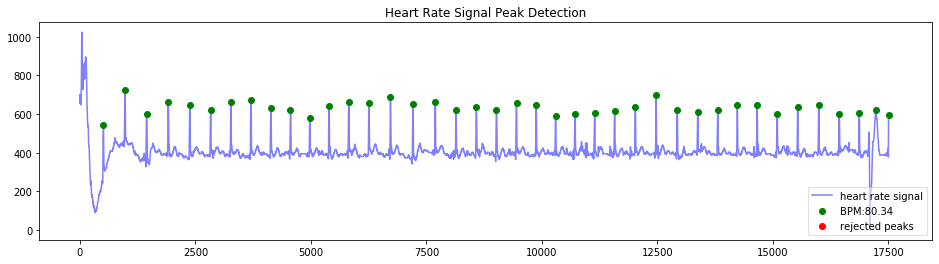

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
0,80.340826,746.81831,58.550553,30.524379,37.240498,0.263158,0.105263,18.852834,25.588112,64.793819,5208.608241,0.394916,NaN


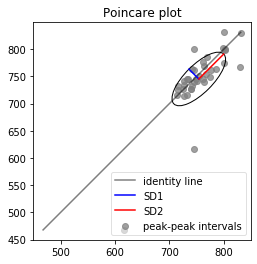

In [8]:
resampled_data = resample(data, len(data) * 4)  # heartpy recommends trying different resampling rates
wd, m = hp.process(hp.scale_data(resampled_data), sample_rate * 4)

plt.figure(figsize=(16,4))
hp.plotter(wd, m)

display(pd.DataFrame([m]))

hp.plot_poincare(wd, m)

### Try again with notch filter

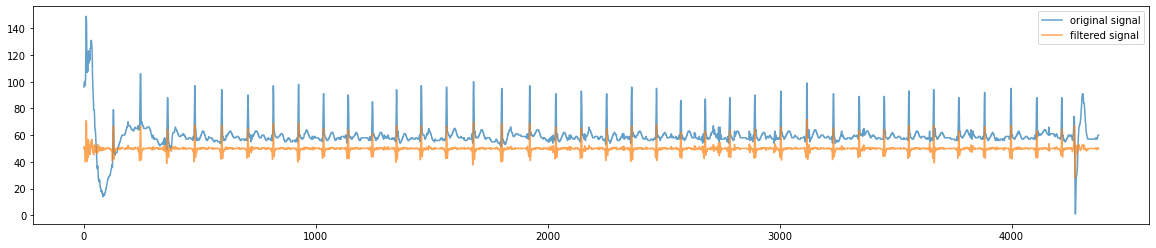

In [9]:
filtered = hp.filter_signal(data, cutoff = 0.05, sample_rate = sample_rate, order=2, filtertype='notch')

plt.figure(figsize=(20,4))
plt.plot(data, alpha=0.7, label = 'original signal')
plt.plot(filtered, alpha=0.7, label = 'filtered signal')
plt.legend();

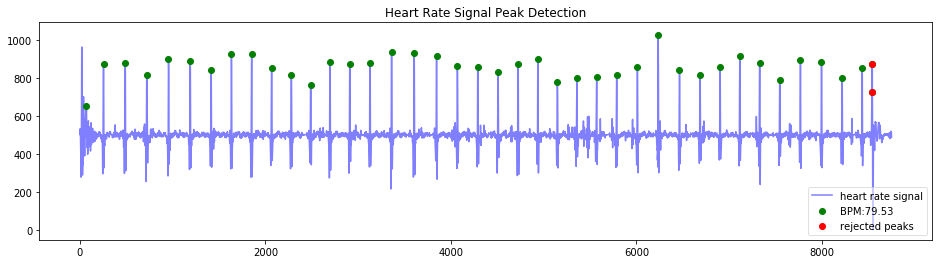

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
0,79.525586,754.474165,36.537791,28.767975,34.728863,0.324324,0.081081,18.852834,24.4558,41.442668,3184.04685,0.590112,0.166667


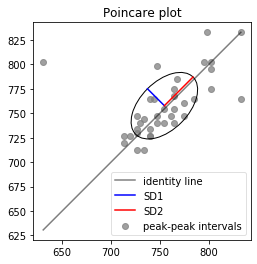

In [10]:
from scipy.signal import resample

resampled_data = resample(filtered, len(filtered) * 2)
wd, m = hp.process(hp.scale_data(resampled_data), sample_rate * 2)

plt.figure(figsize=(16,4))
hp.plotter(wd, m)

display(pd.DataFrame([m]))
    
hp.plot_poincare(wd, m)